In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_excel("Data_ts_801_823.xlsx",sheet_name='801')

In [3]:
df['Posting Date'].min()

Timestamp('2013-01-02 00:00:00')

In [4]:
df['Posting Date'].max()

Timestamp('2021-07-30 00:00:00')

In [5]:
df.head()

,Posting Date,Amount in local currency
0,2021-01-26,43.24
1,2020-10-05,31.85
2,2019-09-27,43.01
3,2019-02-05,16.52
4,2020-02-19,11.62


## Data Preprocessing

In [6]:
df.isnull().sum()

Posting Date                0
Amount in local currency    0
dtype: int64

In [7]:
Cash_801 = df.groupby('Posting Date')['Amount in local currency'].sum().reset_index()

In [8]:
Cash_801.head()

,Posting Date,Amount in local currency
0,2013-01-02,669531.02
1,2013-01-03,7471897.64
2,2013-01-04,1261084.21
3,2013-01-07,1385109.37
4,2013-01-08,1427275.49


## Indexing with time series data

In [9]:
Cash_801 = Cash_801.set_index('Posting Date')
Cash_801.index

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07',
               '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-14', '2013-01-15',
               ...
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-26', '2021-07-27', '2021-07-28',
               '2021-07-29', '2021-07-30'],
              dtype='datetime64[ns]', name='Posting Date', length=2125, freq=None)

In [10]:
y = Cash_801['Amount in local currency'].resample('MS').mean()

Let's peek at year 2013

In [11]:
y['2013':]

Posting Date
2013-01-01    1.136397e+06
2013-02-01    1.045652e+06
2013-03-01    1.237289e+06
2013-04-01    3.001113e+06
2013-05-01    3.867641e+06
                  ...     
2021-03-01    6.628189e+06
2021-04-01    4.374334e+06
2021-05-01    4.787077e+06
2021-06-01    2.881670e+06
2021-07-01    2.522865e+06
Freq: MS, Name: Amount in local currency, Length: 103, dtype: float64

In [12]:
y

Posting Date
2013-01-01    1.136397e+06
2013-02-01    1.045652e+06
2013-03-01    1.237289e+06
2013-04-01    3.001113e+06
2013-05-01    3.867641e+06
                  ...     
2021-03-01    6.628189e+06
2021-04-01    4.374334e+06
2021-05-01    4.787077e+06
2021-06-01    2.881670e+06
2021-07-01    2.522865e+06
Freq: MS, Name: Amount in local currency, Length: 103, dtype: float64

## Visualizing Cash Collection

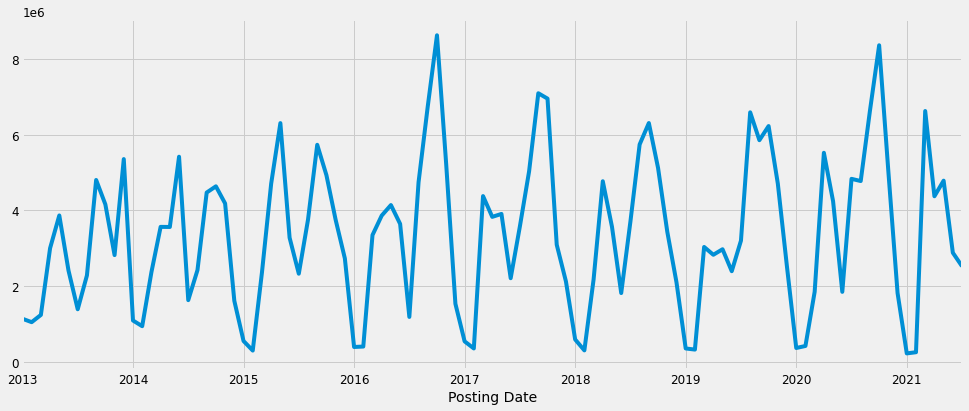

In [13]:
y.plot(figsize=(15, 6))
plt.show()

From the plot above it can be inferred that cash collection has increased over the years and it usually dips towrads the end of the year.

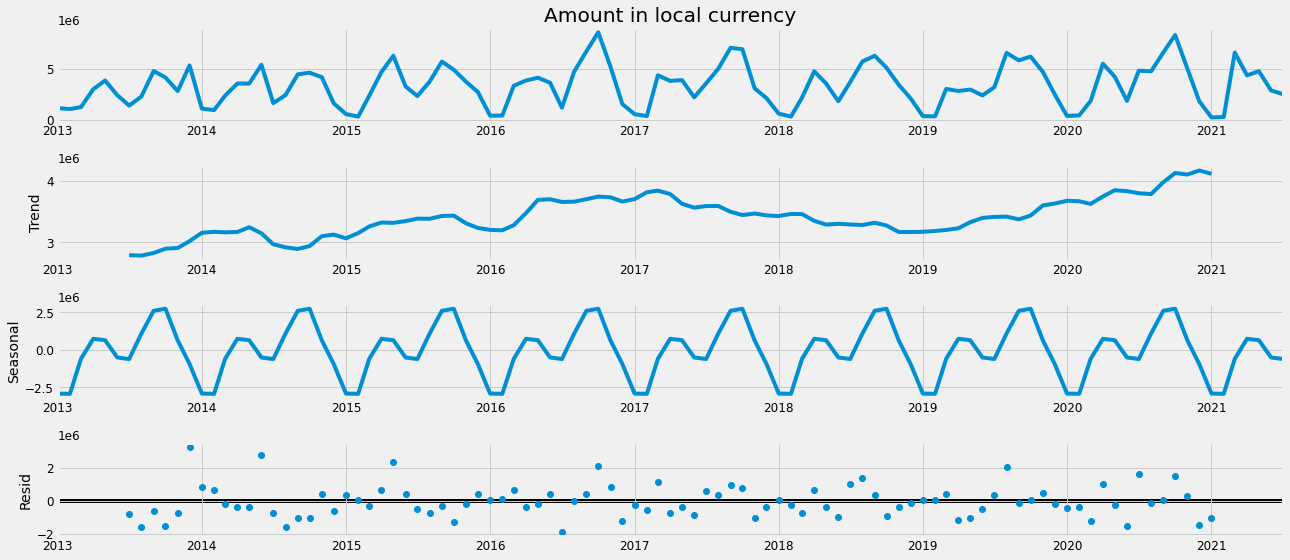

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Cash collection in this legal entity is obviously seasonal.

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average

Parameter Selection for the ARIMA Time Series Model

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [16]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3388.5211699970955
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2949.1992421692275
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2799.018041485737
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2415.1677952703685
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2830.1991386111304
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2794.45089701797
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2440.309416034873
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2411.9081324641816
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3287.270266199532
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2885.830210099383
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2769.4751856294747
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2387.411424840459
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2926.563116566539
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2863.526923907209
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2442.08940082744
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2383.5218170384846
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3217.479234855456
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2829.1519465496617
ARIM

The lowest AIC is

In [27]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8963      0.077    -11.693      0.000      -1.047      -0.746
ma.S.L12      -0.4180      0.167     -2.510      0.012      -0.744      -0.092
sigma2      2.469e+12   1.63e-14   1.52e+26      0.000    2.47e+12    2.47e+12


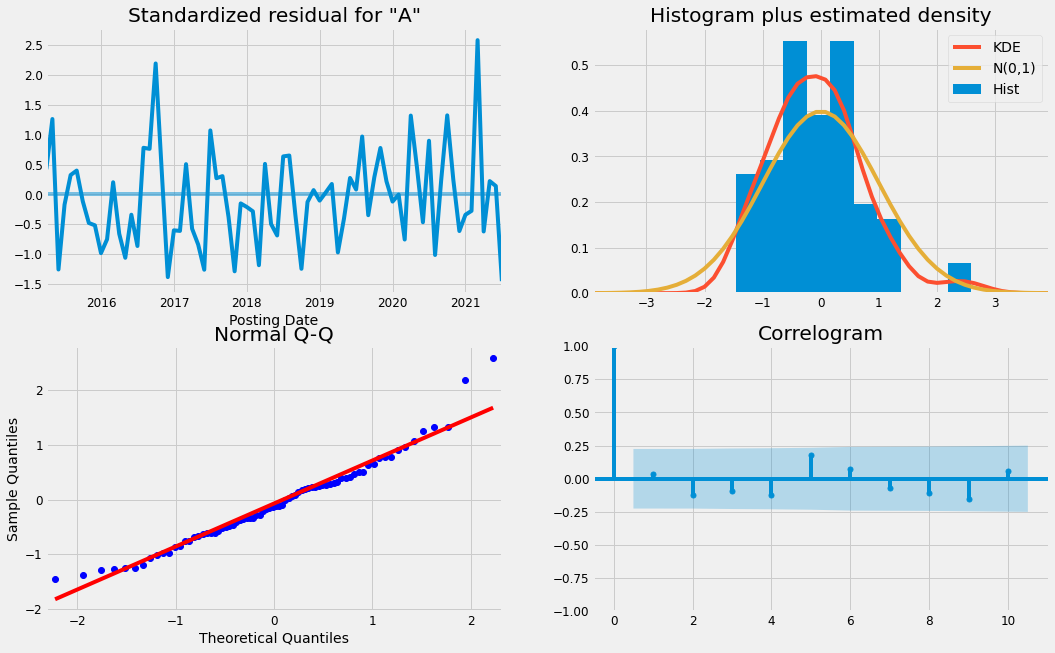

In [28]:
results.plot_diagnostics(figsize=(16, 10))
plt.show()

In [30]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:           Amount in local currency   No. Observations:                  103
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1177.845
Date:                            Wed, 04 Aug 2021   AIC                           2361.690
Time:                                    09:52:03   BIC                           2368.682
Sample:                                01-01-2013   HQIC                          2364.484
                                     - 07-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8963      0.077    -11.693      0.000      -1.047      -0.746
ma.S.L12      -0.4180      0.167     -2.510      0.012      -0.744      -0.092
sigma2      2.469e+12   1.63e-14   1.52e+26      0.000    2.47e+12    2.47e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 8.96
Prob(Q):                              0.77   Prob(JB):                         0.01
Heteroskedasticity (H):               1.03   Skew:                             0.70
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.59e+42. Standard errors may be unstable.
"""

## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017-07-01 to the end of the data.

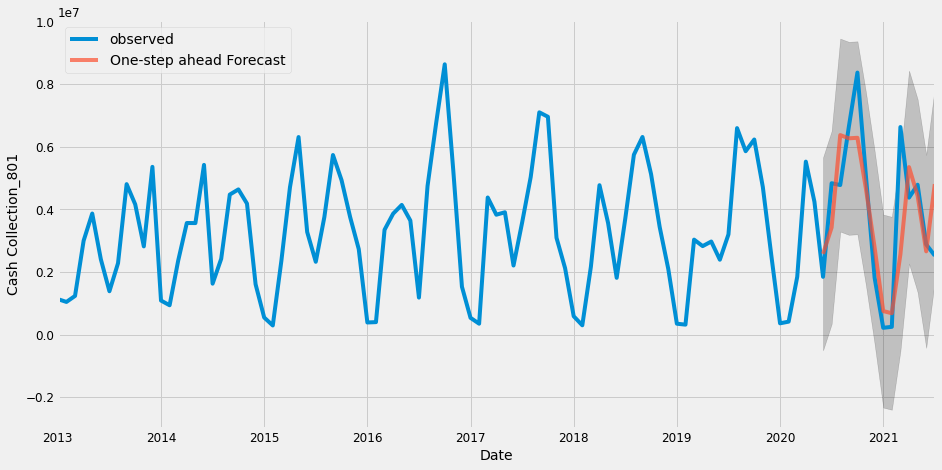

In [31]:
pred = results.get_prediction(start=pd.to_datetime('2020-06-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Cash Collection_801')
plt.legend()

plt.show()

The predictions were almost in line with the actual results, so our accuracy is great.

In [32]:
y_forecasted = pred.predicted_mean
y_truth = y['2020-06-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2423574163426.13


In [33]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 1556783.27


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily cash collection in the test set within 1556783.27 of the real sales. Our daily cash collection ranges from around -15122277 to over 25969582.19. In my opinion, this is a pretty good model so far.

In [34]:
df['Amount in local currency'].min()

-15122277.0

In [35]:
df['Amount in local currency'].max()

25969582.19

## Producing and visualizing forecasts

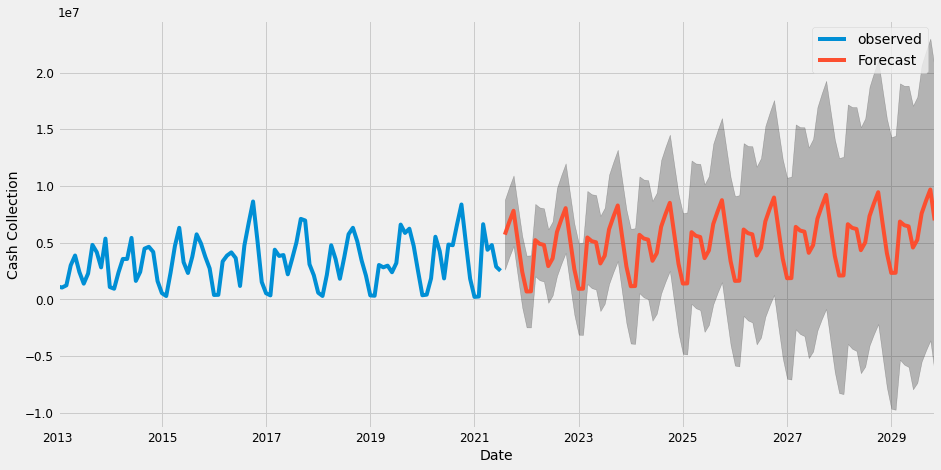

In [36]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Cash Collection')

plt.legend()
plt.show()

Our model clearly captured cash collection seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

In [37]:
pred_ci.head(10)

,lower Amount in local currency,upper Amount in local currency
2021-08-01,2.627715e+06,8.786808e+06
2021-09-01,3.717287e+06,9.909382e+06
2021-10-01,4.700901e+06,1.092582e+07
2021-11-01,1.965196e+06,8.222771e+06
2021-12-01,-7.153023e+05,5.574756e+06
2022-01-01,-2.466032e+06,3.856344e+06
2022-02-01,-2.470563e+06,3.883965e+06
2022-03-01,2.030670e+06,8.417190e+06
2022-04-01,1.690435e+06,8.108786e+06
2022-05-01,1.575492e+06,8.025518e+06


In [42]:
prediction_df = pd.DataFrame(data=pred_ci)
prediction_df.to_csv('predictions.csv')
#score = score_submission(pred_path='predictions.csv')